# **Task 5: Analysis of Extragalactic Objects' Spectra:**
This example meant to walk you through the basic analysis of 1-dimension spectra of extragalactic objects such as galaxies and active galactic nuclei. The example spectra has been wavelength and flux calibrated.  

Install the following require packages:


*   astroquery
*   astropy
*   extinction




In [1]:
"""
!pip install astropy
!pip install astroquery
!pip install extinction
!pip install astroML
"""

'\n!pip install astropy\n!pip install astroquery\n!pip install extinction\n!pip install astroML\n'

First, let's call in the usual suspects (i.e. import normally used packages)


*   NumPy
*   SciPy
*   Matplotlib.Pyplot

And also the packages you just installed (for online participants).



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

from astroquery.sdss import SDSS
from astroML.datasets import fetch_sdss_spectrum # Pick one of this function

from scipy.optimize import curve_fit
from urllib.error import HTTPError



#**Block 5.1:**
Now, we can assume that an emission feature of the spectra follow a certain well-known shape--Gaussian Distribution. Caveat: This assumption hold true for most cases (but not all cases).

gaussian_function.svg

Let's define a function for gaussian distribution, where f(x) is the flux density (in the unit of erg/s/cm^2/angstrom for instance) and "x" as wavelength.

In [3]:
def gaussian_profile(x,scale_height,centroid,sigma):
  flux_dens = scale_height * np.exp(-0.5 * ((x - centroid)/sigma)**2 ) # build a function where x represent the wavelength 
  return flux_dens

Now, test that your function is working properly.

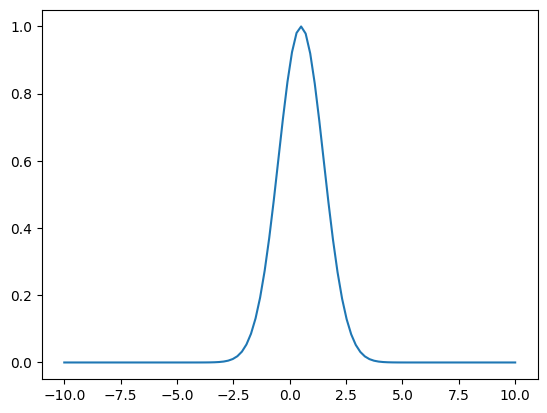

In [4]:
x_test = np.linspace(-10.0,10.0,100) # this is dummy x variable range from -10 to 10 with 100 elements
centroid_test =  0.5
sigma_test = 1.0
scale_height = 1.0
flux_dens_test = gaussian_profile(x_test,scale_height,centroid_test,sigma_test)

plt.plot(x_test, flux_dens_test)
plt.show()

#**Block 5.2:**
**Good, good, good!**

Now, we are (somewhat) ready to fit some emission lines.

*   Read in (download) the a spectrum of a suspected active galactic nucleus.
*   Use the text file provided (in data/ folder).
*   Select any source in that file.
*   Use astroquery to obtain its spectrum from the SDSS survey.


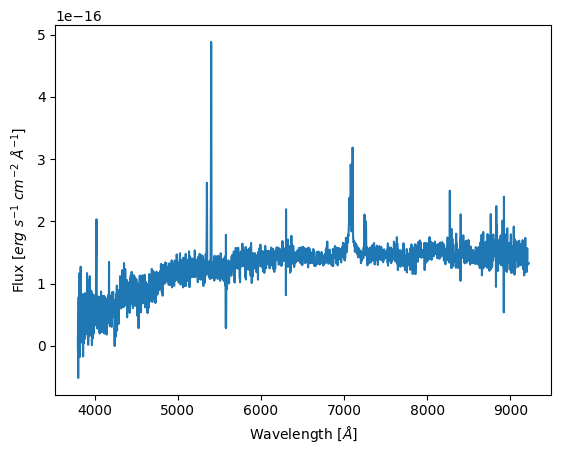

In [5]:
data_file_path = 'data/table_dr17_all_low_luminosity_AGN.csv' # check what is the correct path here
#objID, ra, dec, plate, fiberID, redshift_table, mjd = np.loadtxt(data_file_path, usecols=("specObjID", "ra", "dec", "plate", "fiberID", "redshift", "mjd"), unpack=True, skiprows=1, delimiter=' ')

import pandas as pd

# So, I decided to come up with my version
df = pd.read_csv(data_file_path)
objID, ra, dec, plate, fiberID, redshift_table, mjd = df[["specObjID", "ra", "dec", "plate", "fiberID", "redshift", "mjd"]].values.T

def get_sdss_spec(plate,mjd,fiber): # in Place of 'Macro subtract_plot 13'
    try:
        spec = fetch_sdss_spectrum(plate, mjd, fiber)
    except HTTPError:
        print("%i, %i, %i not found" % (plate, mjd, fiber))
        spec = None
    return spec

index = 3

spec1 = get_sdss_spec(plate[index],mjd[index],fiberID[index])

wvl_1      = spec1.wavelength()*u.AA
flux_1     = spec1.spectrum*1.0e-17 *u.Unit('erg s^-1 cm^-2 AA^-1')
flux_err_1 = spec1.error
z_listed_1 = spec1.z

plt.plot(wvl_1,flux_1) # Quick look at the spectrum
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Now, zoom in to see whether you can recognize any prominent emission feature, like HAlpha?


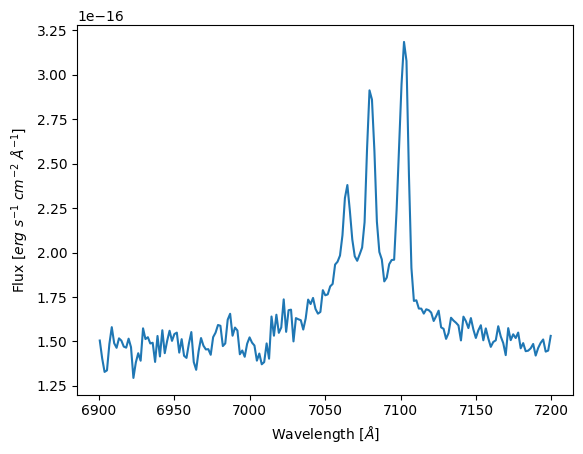

In [6]:
lambda_start = 6900.0
lambda_end   = 7200.0
slice_1 = np.where((wvl_1/u.AA > lambda_start) & (wvl_1/u.AA < lambda_end)) # Change Lambda_start and Lambda_end to match the range you want to zoom into.
plt.plot(wvl_1[slice_1],flux_1[slice_1])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

#**Block 5.3:**
**Is single Gaussian fit gonna be enough?**

As you might have realized at this point, this is possibly a blended gaussian with multiple narrow lines and (maybe) a broad component. The spectral resolution of SDSS at R~1000 does not help either.
This features is typical for what we call Seyfert-I galaxies, which is an AGN with visible host galaxy.


*   Build on your gaussian function defined earlier.
*   Transform it into multiple-Gaussian model (3 narrow lines + 1 broad component)
*   Use the new model to fit the spectrum and obtain the best-fitted redshift.
*   Compared this to the redshift you obtain from SDSS catalog.
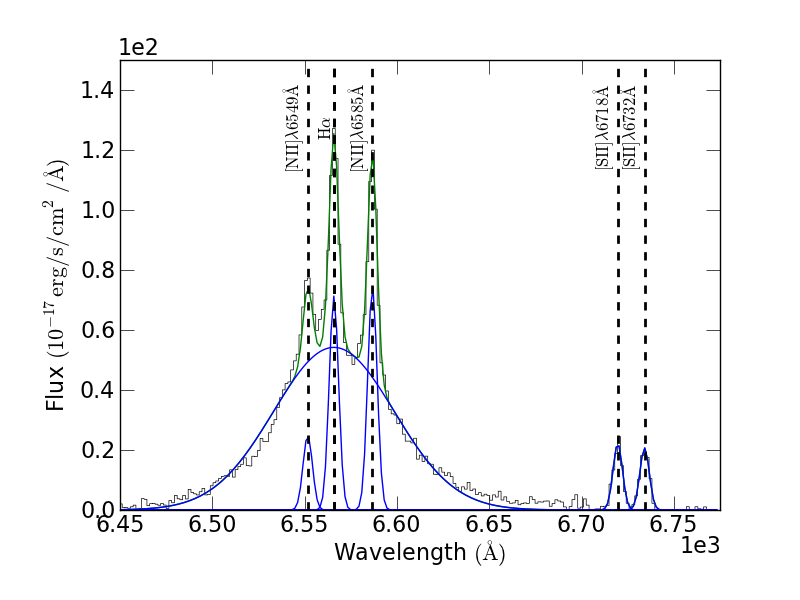.


In [7]:
NIIa = 6549.86
NIIb = 6585.27
Halpha = 6564.614

peak_guess0 = 7070.0
peak_guess1 = (peak_guess0/Halpha)*NIIa
peak_guess2 = (peak_guess0/Halpha)*NIIb
peak_guess3 = (peak_guess0/NIIa)*NIIb

X = wvl_1[slice_1].to(u.angstrom).value # Convert wavelength to nm
Y = flux_1[slice_1].to(u.Unit('erg s^-1 cm^-2 AA^-1')).value # Convert flux to W/m^2/nm

def multi_gaussian4(x,x0, x1, x2, x3, h0, h1, h2, h3, s0, s1, s2, s3, thres):
  f0 = gaussian_profile(x,h0,(peak_guess0 + x0),s0)
  f1 = gaussian_profile(x,h1,(peak_guess1 + x1) ,s1)
  f2 = gaussian_profile(x,h2,(peak_guess2 + x2) ,s2)
  f3 = gaussian_profile(x,h3,(peak_guess3 + x3) ,s3)
  f_total = f0 + f1 + f2 + f3 + thres
  return f_total

p_agn1, pv_agn1 = curve_fit(multi_gaussian4, X, Y, \
  p0 = [0.1, 0.1, 0.1, 0.1, 2e-16, 2e-16, 2e-16, 2e-16, 10.0, 10.0, 10.0, 10.0, 5e-16]) 
  # p0 is the initial guess for the parameters
print(p_agn1)


[ 1.02380487e+01  2.44319130e+01 -2.78965608e+01 -6.02976372e+00
  1.01448697e-16  4.44941704e-17  4.65547766e-17  1.41020921e-16
  2.52573928e+00  3.09037969e+01  2.77600952e+00 -2.72955663e+00
  1.48338751e-16]


#**Block 5.4:**
**Beautify Your Plot of Multi-Gaussian Fit**

Now, it is time to show your result. Really, zoom in to the region just surrounding the H-alpha and [NII] doublets. Plot the spectrum and the best-fitted model with different components (narrow and broad features and the continuum).

Don't forget to label your axes.

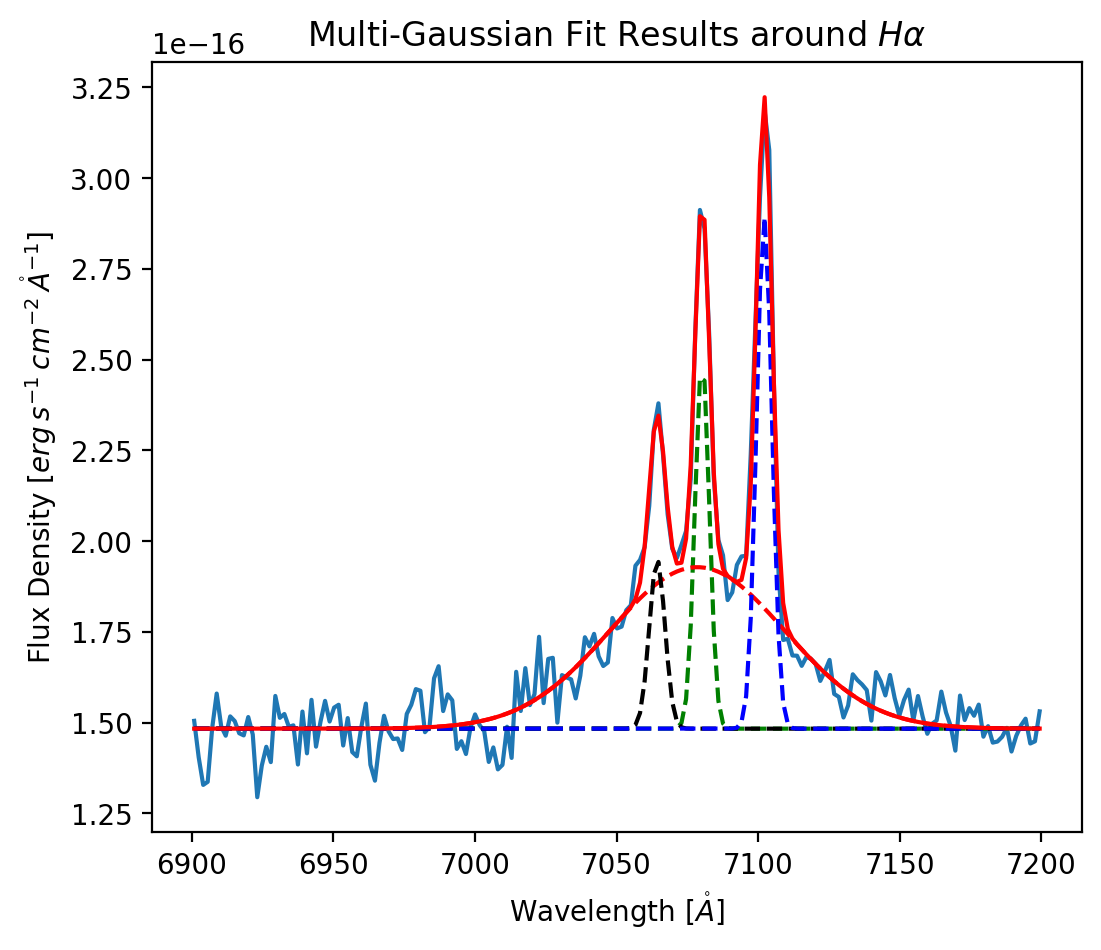

In [8]:
x0_opt, x1_opt, x2_opt, x3_opt, h0_opt, h1_opt, h2_opt, h3_opt, s0_opt, s1_opt, s2_opt, s3_opt, thres_opt = p_agn1

fig = plt.figure(figsize=(6,5), dpi=200)
plt.plot(wvl_1[slice_1], flux_1[slice_1])
plt.plot(X, gaussian_profile(X, h0_opt,(peak_guess0 + x0_opt),s0_opt) + thres_opt, 'g--')
plt.plot(X, gaussian_profile(X, h1_opt,(peak_guess1 + x1_opt),s1_opt) + thres_opt, 'r--')
plt.plot(X, gaussian_profile(X, h2_opt,(peak_guess2 + x2_opt),s2_opt) + thres_opt, 'k--')
plt.plot(X, gaussian_profile(X, h3_opt,(peak_guess3 + x3_opt),s3_opt) + thres_opt, 'b--')

plt.plot(X, multi_gaussian4(X, *p_agn1), 'r-')
plt.title(r'Multi-Gaussian Fit Results around $H\alpha$')
plt.xlabel(r'Wavelength [$\mathring{A}$]')
plt.ylabel(r'Flux Density [$erg\: s^{-1} \: cm^{-2} \: \mathring{A}^{-1}$]')
#plt.legend()
plt.show()


#**Block 5.5:**
**What about H-Beta**

Since we know the redshift (from the fit), we should be able to locate H-Beta (rest-wavelength around 4861 angstrom).

*   Use the obtained redshift to zoom in on H-Beta
*   Perform a multi-gaussian fit on the emission features around H-Beta.
*   Obtain the broad component of H-Beta.
*   Get the "rest-frame" velocity dispersion of the broad H-Beta emission in km/s and the "luminosity density" around 5100 angstrom.
*   Calculate the SMBH mass from the following equation (Park et al. 2015):

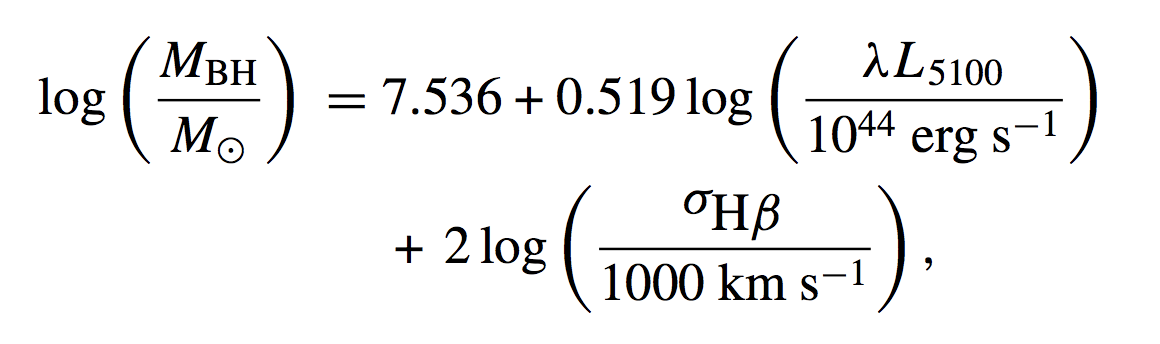


In [9]:
def log_M_BH_Park2015(wavelength,velocity_dispersion_hbeta): # You only need 2 variables here
    log_M_BH_Park2015_est = 7.536 + 0.519 * np.log10(wavelength * L / (1e44 * 1.0 * u.erg/u.s)) + 2.0 * np.log10(velocity_dispersion_hbeta * (1.0 * u.km/u.s) /(1000.0 * u.km/u.s)))
    return log_M_BH_Park2015_est

SyntaxError: unmatched ')' (918951856.py, line 2)

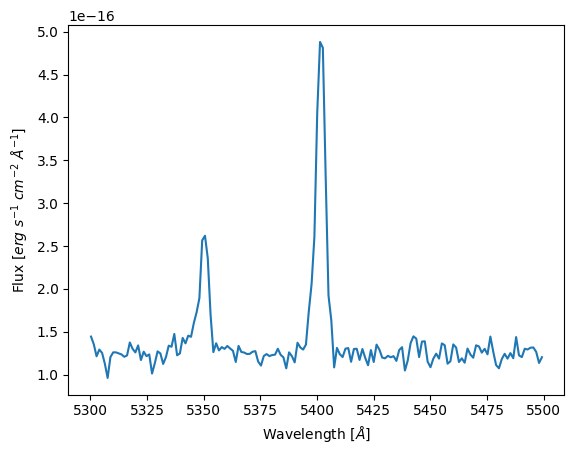

4880.818860261334
5026.878442727099


In [ ]:
HBeta = 4862.721
OIIIa = 4960.295
OIIIb = 5008.239

lambda_start = 5300.0
lambda_end   = 5500.0

slice_2 = np.where((wvl_1/u.AA > lambda_start) & (wvl_1/u.AA < lambda_end))
plt.plot(wvl_1[slice_2], flux_1[slice_2])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

z_fitted = x1_opt/Halpha
print(HBeta*(1.0+z_fitted))
print(OIIIb*(1.0+z_fitted))

In [ ]:
peak_guess0 = HBeta
peak_guess1 = ...
peak_guess2 = ...
peak_guess3 = ...

p_agn2, pv_agn2 = curve_fit(multi_gaussian4, wvl_1.value[slice_2], flux_1.value[slice_2])

fig = plt.figure(figsize=(6,5), dpi=200)
...
...
...
plt.show()

print(p_agn2[12])



Now, it seemed like you broke Python...

But, did you?

Discuss, why it does or doesn't work.

What is wrong?

Could we calculate the mass of Super Massive Black Hole anyway???

In [ ]:
f5100 = p_agn2[12]

cosmo = FlatLambdaCDM(H0 = 70.0 * u.km / u.s / u.Mpc, Om0 = 0.30, Tcmb0 = 2.725 * u.K)
xMpc = 1.0e+6 * u.parsec
cm_in_Mpc = xMpc.to(u.cm).value

d_L = (cosmo.luminosity_distance(your_redshift_value).value)*cm_in_Mpc
L5100 = f5100* ... # surface area in a function of d_L

print(L5100)

#Is it possible that the velocity dispersion of Balmer emission features are the same? 

In [ ]:
log_M_smbh = log_M_BH_Park2015(...)
print(log_M_smbh)